In [1]:
import matplotlib.pylab as plt
import numpy as np
from torchvision.io import read_image
import urllib.request
from PIL import Image

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

from absl import logging

logging.set_verbosity(logging.INFO)

# import utils
from uio import runner

In [2]:
# uio = runner.ModelRunner("base", "base.bin")
# uio = runner.ModelRunner("large", "large.bin")
uio = runner.ModelRunner("xl", "xl.bin")
# uio = runner.ModelRunner("small", "small.bin")

INFO:absl:Setting up model...
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
INFO:absl:Loading parameters...
INFO:absl:Model is ready


In [3]:
import matplotlib.patches as patches


def show_images(images, nrow=3, scale=6):
    if len(images.shape) == 4 and images.shape[0] == 1:
        images = images[0]
    if len(images.shape) == 3:
        fig, ax = plt.subplots()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.imshow(images)
        plt.show()
    else:
        n = images.shape[0]
        ncol = (n + nrow - 1) // nrow
        if ncol == 1:
            nrow = min(nrow, n)
        fig, axes = plt.subplots(
            ncol, nrow, sharex=True, sharey=True, figsize=(scale * nrow, scale * ncol)
        )
        if ncol > 1:
            axes = [item for rows in axes for item in rows]
        i = 0
        for ax, im in zip(axes, images):
            ax.imshow(im)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
        fig.subplots_adjust(wspace=0, hspace=0)
        fig.show()


def show_location(input_image, boxes, labels=None):
    fig, ax = plt.subplots()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    for i in range(len(boxes)):
        x1, y1, x2, y2 = boxes[i].tolist()
        w = x2 - x1
        h = y2 - y1
        rect = patches.Rectangle(
            (x1, y1), w, h, linewidth=1, edgecolor="r", facecolor="none"
        )
        if labels is not None:
            plt.text(x1, y1, labels[i], color="r")
        ax.add_patch(rect)

    ax.imshow(input_image)
    plt.show()


def show_pose(boxes, labels, image):
    fig, ax = plt.subplots()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    for x1, y1 in boxes[labels > 0]:
        rect = patches.Rectangle(
            (x1, y1), 4, 4, linewidth=1, edgecolor="r", facecolor="r"
        )
        ax.add_patch(rect)
    ax.imshow(image)
    plt.show()


def load_image_from_url(url):
    with urllib.request.urlopen(url) as f:
        img = Image.open(f)
        return np.array(img)

In [4]:
hotel_img = load_image_from_url(
    "https://farm2.staticflickr.com/1362/1261465554_95741e918b_z.jpg"
)
tennis_img = load_image_from_url(
    "https://farm9.staticflickr.com/8313/7954229658_03f8e8d855_z.jpg"
)
# penguin_img = load_image_from_url('https://i.stack.imgur.com/z9vLx.jpg')
test_img = img = np.array(Image.open("./000000009448.jpg"))

In [5]:
uio.caption(test_img)["text"]

INFO:absl:Running model text_inputs=['What does the image describe ?']


'a little girl holding an umbrella in the rain.'

In [6]:
uio.vqa(test_img, "what color is girl's hair?")["text"]

INFO:absl:Running model text_inputs=["what color is girl's hair?"]


'blonde'

In [7]:
# Image classification support a list of answer options to support different category sets
out = uio.image_classification(test_img, answer_options=["umbrella", "hand"])
out

INFO:absl:Running model text_inputs=['What is this in the image ?'] and 2 answer options


{'text': 'umbrella', 'score': array([0.6201545], dtype=float32)}

Input location:


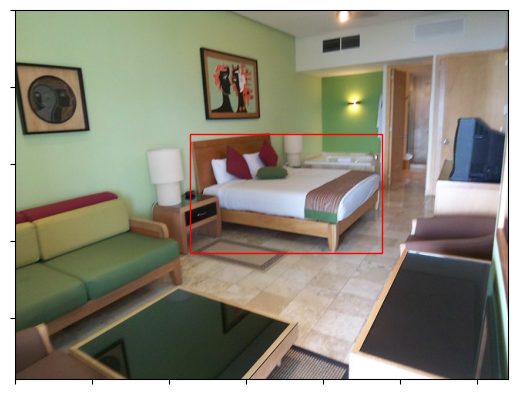

INFO:absl:Running model text_inputs=['What is the category of region " <extra_id_350> <extra_id_453> <extra_id_593> <extra_id_843> " ?'] and 3 answer options


'bed'

In [8]:
box = [226.56, 160.64, 476.16, 316.16]
print("Input location:")
show_location(hotel_img, np.array([box]))
out = uio.region_classification(hotel_img, box, answer_options=["bed", "chair", "sofa"])
out["text"]

INFO:absl:Running model text_inputs=['What is the depth map of the image ?']


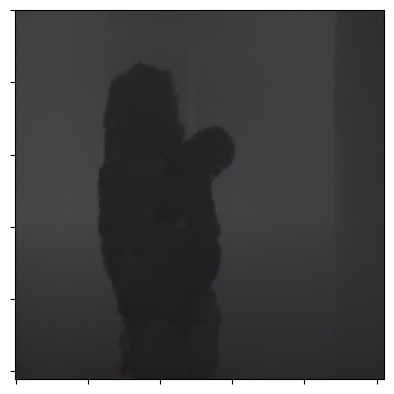

In [9]:
out = uio.depth(test_img, num_decodes=None)
show_images(out["image"])

INFO:absl:Running model text_inputs=['What is the surface normal of the image ?']


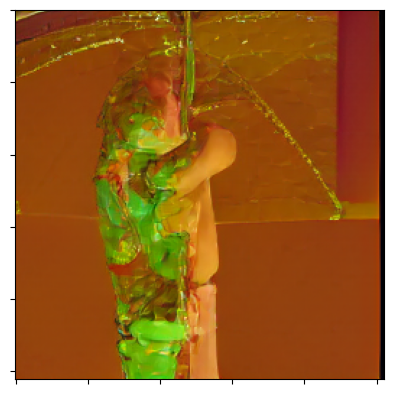

In [10]:
out = uio.surface_normal(test_img)
show_images(out["image"])

INFO:absl:Running model text_inputs=['What is the complete image? Text: " a girl holding a umbrella . " .']


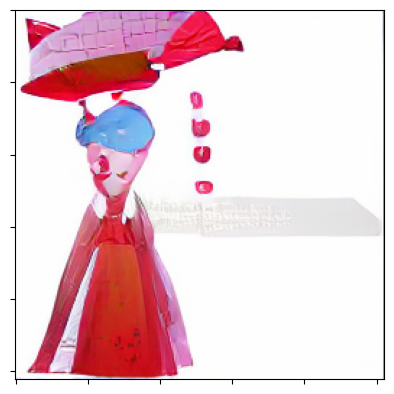

In [7]:
out = uio.image_generation("a girl holding a umbrella .", num_decodes=1)
show_images(out["image"])

INFO:absl:Running model text_inputs=['What is the segmentation of " painting " ?']


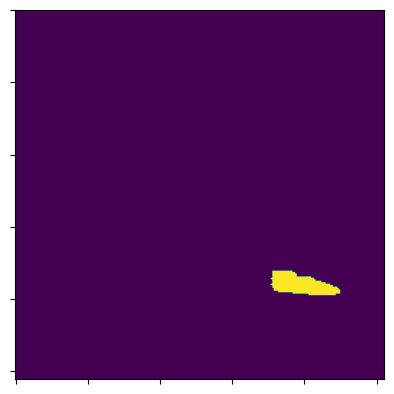

In [12]:
out = uio.object_segmentation(hotel_img, "painting")
# show_images(out["image"])
# print(out["mask"])
# mask will be a list of binary masks, on for each instance
show_images(np.expand_dims(np.stack(out["mask"]), -1))

INFO:absl:Running model text_inputs=['Which region does the text " girl " describe ?']


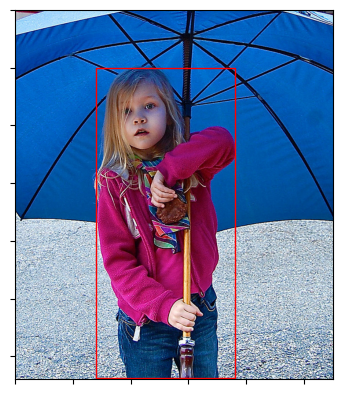

[[140.8  100.48 380.8  638.08]]


In [8]:
out = uio.refexp(test_img, "girl")
show_location(test_img, out["boxes"])
print(out["boxes"])

In [9]:
out = uio.region_caption(hotel_img, box)
out["text"]

NameError: name 'box' is not defined

In [11]:
box = [140.8,100.48,380.8,638.08]
out = uio.pose(test_img, box)
show_pose(out["points"], out["labels"], test_img)

INFO:absl:Running model text_inputs=['Find the human joints in the region " <extra_id_256> <extra_id_319> <extra_id_1096> <extra_id_694> " .']


IndexError: piece id is out of range.

INFO:absl:Running model text_inputs=['Filling the blank region " <extra_id_256> <extra_id_319> <extra_id_1096> <extra_id_694> boy " ?']


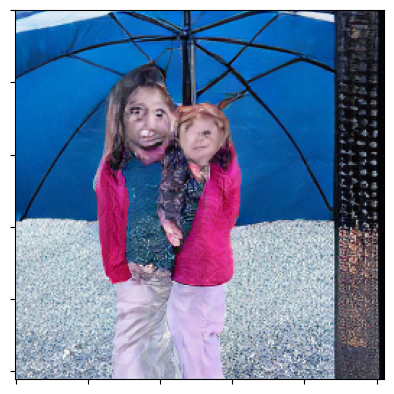

In [15]:
box = [140.8, 100.48, 380.8, 638.08]
out = uio.image_inpainting(test_img, box, "boy", 1)
show_images(out["image"])

In [ ]:
# image = read_image('dbg_penguin_outline.jpg').numpy().transpose(1, 2, 0)
out = uio.segmentation_based_generation(
    [penguin_img[:, :, 0] > 10], ["penguin"], num_decodes=4
)
show_images(out["image"])

NameError: name 'penguin_img' is not defined

In [12]:
question = "one plus one equals?"
num_decodes = 1
out = uio.run([None], [question.lower()], output_text_len=32,
                   generate_image=False, num_decodes=num_decodes)

INFO:absl:Running model text_inputs=['one plus one equals?']


In [13]:
uio._extract_text(out)

{'text': ['plus one equals?'], 'score': array([-3.2239556], dtype=float32)}